In [ ]:
!pip install pyprind
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from torchtext import data
import torchtext
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))
print(torch.cuda.get_device_name())
import torch.nn.functional as F
import torch.nn as nn
import pyprind
#%matplotlib inline  
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Cuda Status on system is True
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dest = '/content/drive/My Drive/Fake_News_Detection/'

Mounted at /content/drive


Preparation  of Dataset


In [ ]:
main_df = pd.read_csv(dest + "new_news.csv")
print(main_df.shape)
clean_df=main_df[['post','numeric_label']]
clean_df=clean_df.dropna()
print(clean_df.head())
print(clean_df.shape)
X=clean_df['post']
y=clean_df['numeric_label']



(6299, 4)
                                                post  numeric_label
0  The 8th Democratic Debate In 100 Words (And 4 ...              0
1  Supreme Court throws out conviction for violen...              0
2  John Kerry: ISIS responsible for genocide. (CN...              0
3  The GOP case against Loretta Lynch falls apart...              0
4  Is Campus Rape Really An Epidemic?. A document...              0
(6299, 2)


Splitting the Test Train Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train,X_valid,y_train,y_valid=train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print(f'Size of Train set {X_train.shape}\nSize of Test set {X_test.shape}\nSize of valid set {X_valid.shape}\n')

Size of Train set (4535,)
Size of Test set (630,)
Size of valid set (1134,)



In [ ]:
train = pd.concat([X_train, y_train], axis=1)
print(train.shape)

valid = pd.concat([X_valid, y_valid], axis=1)
print(valid.shape)

test = pd.concat([X_test, y_test], axis=1)
print(test.shape)

(4535, 2)
(1134, 2)
(630, 2)


In [ ]:
train.to_csv(dest + "train.csv", index=False)
test.to_csv(dest + "test.csv", index=False)
valid.to_csv(dest + "valid.csv", index=False)

In [ ]:
del main_df, train, test, valid, X_train, X_test, y_train, y_test,X_valid,y_valid,clean_df

Tokenizing Dataset and using Pytorchtext


In [ ]:
def tokenizer(text):
    return [tok for tok in nltk.word_tokenize(text)]

In [ ]:
TEXT = data.Field(sequential=True, tokenize=tokenizer,include_lengths = True)
LABEL = data.LabelField(dtype=torch.float, sequential=False)

In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits(
    path=dest, train="train.csv", validation="valid.csv", 
    test="test.csv", format="csv", skip_header=True, 
    fields=[('post', TEXT), ('numeric_Label', LABEL)]
)

In [ ]:
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors(dest + "glove.840B.300d.txt"), 
                 max_size=50000)
LABEL.build_vocab(train_data)

100%|█████████▉| 2195914/2196017 [04:00<00:00, 10114.36it/s]

In [ ]:
# Hyperparameters
num_epochs = 40
learning_rate = 1e-5 

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1
#N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.01
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
BATCH_SIZE = 16

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.post),sort_within_batch = True,
    batch_size=BATCH_SIZE,
    device=device)

cuda


In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        rel = self.relu(cat)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        preds = self.fc2(drop)
        return preds
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [ ]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,  
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([47220, 300])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [ ]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

        

In [ ]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        text, text_lengths = batch.post
      
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.numeric_Label)
        acc = binary_accuracy(predictions, batch.numeric_Label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator,mode):
    
    epoch_acc = 0
    epoch_loss=0
    preds,labels=[],[]
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:
            
            text, text_lengths = batch.post
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.numeric_Label)
            loss = criterion(predictions, batch.numeric_Label)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            logits = rounded_preds.detach().cpu().numpy()
            label_ids = batch.numeric_Label.to('cpu').numpy()
            
            preds.append(logits)
            labels.append(label_ids)

            epoch_acc += acc.item()
            epoch_loss+=loss.item()
            bar.update()
    if mode =="validation":        
      return epoch_acc / len(iterator),epoch_loss / len(iterator)
    if mode =="testing":
      return epoch_acc / len(iterator),epoch_loss / len(iterator),preds,labels


In [ ]:
t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]
for epoch in range(num_epochs):
    print(f'Epoch Number: {epoch}\n')
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator,mode="validation")
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    #print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)

print(f'time:{time.time()-t:.3f}')

Epoch Number: 0



0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.691 | Train Acc: 51.14%
	Val. Loss: 0.689 | Val. Acc: 51.48%
Epoch Number: 1




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.686 | Train Acc: 56.11%
	Val. Loss: 0.683 | Val. Acc: 56.33%
Epoch Number: 2




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.676 | Train Acc: 66.03%
	Val. Loss: 0.671 | Val. Acc: 68.41%
Epoch Number: 3




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.652 | Train Acc: 75.81%
	Val. Loss: 0.632 | Val. Acc: 74.94%
Epoch Number: 4




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.551 | Train Acc: 79.91%
	Val. Loss: 0.477 | Val. Acc: 82.73%
Epoch Number: 5




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.407 | Train Acc: 85.54%
	Val. Loss: 0.388 | Val. Acc: 85.99%
Epoch Number: 6




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.353 | Train Acc: 86.86%
	Val. Loss: 0.374 | Val. Acc: 85.46%
Epoch Number: 7




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.330 | Train Acc: 87.71%
	Val. Loss: 0.348 | Val. Acc: 86.52%
Epoch Number: 8




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.315 | Train Acc: 88.51%
	Val. Loss: 0.339 | Val. Acc: 85.99%
Epoch Number: 9




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.301 | Train Acc: 88.95%
	Val. Loss: 0.322 | Val. Acc: 87.75%
Epoch Number: 10




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.291 | Train Acc: 89.46%
	Val. Loss: 0.312 | Val. Acc: 87.76%
Epoch Number: 11




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.278 | Train Acc: 90.14%
	Val. Loss: 0.300 | Val. Acc: 88.72%
Epoch Number: 12




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.269 | Train Acc: 90.51%
	Val. Loss: 0.286 | Val. Acc: 88.82%
Epoch Number: 13




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.254 | Train Acc: 90.95%
	Val. Loss: 0.274 | Val. Acc: 89.70%
Epoch Number: 14




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.240 | Train Acc: 91.42%
	Val. Loss: 0.258 | Val. Acc: 90.58%
Epoch Number: 15




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.224 | Train Acc: 92.06%
	Val. Loss: 0.247 | Val. Acc: 91.20%
Epoch Number: 16




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.213 | Train Acc: 92.58%
	Val. Loss: 0.235 | Val. Acc: 91.37%
Epoch Number: 17




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.199 | Train Acc: 93.29%
	Val. Loss: 0.239 | Val. Acc: 89.88%
Epoch Number: 18




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


	Train Loss: 0.192 | Train Acc: 93.35%
	Val. Loss: 0.220 | Val. Acc: 91.81%
Epoch Number: 19



0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.180 | Train Acc: 93.86%
	Val. Loss: 0.213 | Val. Acc: 92.78%
Epoch Number: 20




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.172 | Train Acc: 94.25%
	Val. Loss: 0.206 | Val. Acc: 92.08%
Epoch Number: 21




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.161 | Train Acc: 94.61%
	Val. Loss: 0.202 | Val. Acc: 92.96%
Epoch Number: 22




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.155 | Train Acc: 94.71%
	Val. Loss: 0.200 | Val. Acc: 92.69%
Epoch Number: 23




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.149 | Train Acc: 95.14%
	Val. Loss: 0.197 | Val. Acc: 93.13%
Epoch Number: 24




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.143 | Train Acc: 95.25%
	Val. Loss: 0.195 | Val. Acc: 93.13%
Epoch Number: 25




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.137 | Train Acc: 95.47%
	Val. Loss: 0.196 | Val. Acc: 93.22%
Epoch Number: 26




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.133 | Train Acc: 95.42%
	Val. Loss: 0.185 | Val. Acc: 93.31%
Epoch Number: 27




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.126 | Train Acc: 95.62%
	Val. Loss: 0.195 | Val. Acc: 93.05%
Epoch Number: 28




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.126 | Train Acc: 95.77%
	Val. Loss: 0.194 | Val. Acc: 92.96%
Epoch Number: 29




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.118 | Train Acc: 96.15%
	Val. Loss: 0.199 | Val. Acc: 92.52%
Epoch Number: 30




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.116 | Train Acc: 96.03%
	Val. Loss: 0.186 | Val. Acc: 93.05%
Epoch Number: 31




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.109 | Train Acc: 96.41%
	Val. Loss: 0.182 | Val. Acc: 93.13%
Epoch Number: 32




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

	Train Loss: 0.103 | Train Acc: 96.54%
	Val. Loss: 0.188 | Val. Acc: 92.61%
Epoch Number: 33




0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.100 | Train Acc: 96.85%
	Val. Loss: 0.187 | Val. Acc: 92.96%
Epoch Number: 34




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.097 | Train Acc: 97.01%
	Val. Loss: 0.184 | Val. Acc: 92.96%
Epoch Number: 35




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.092 | Train Acc: 97.18%
	Val. Loss: 0.186 | Val. Acc: 92.78%
Epoch Number: 36




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.090 | Train Acc: 97.05%
	Val. Loss: 0.185 | Val. Acc: 92.69%
Epoch Number: 37




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.088 | Train Acc: 97.47%
	Val. Loss: 0.193 | Val. Acc: 92.96%
Epoch Number: 38




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.090 | Train Acc: 97.27%
	Val. Loss: 0.188 | Val. Acc: 93.22%
Epoch Number: 39




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.087 | Train Acc: 97.21%
	Val. Loss: 0.181 | Val. Acc: 93.05%
time:305.969



Total time elapsed: 00:00:00


<function matplotlib.pyplot.show>

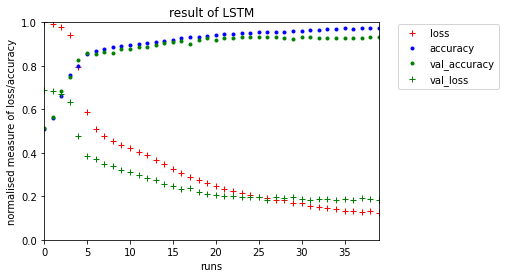

In [ ]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(val_loss)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r+',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.plot(x_len, val_loss, 'g+', label="val_loss")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [ ]:
test_acc,test_loss,preds,labels = evaluate(model, test_iterator,mode="testing")

preds = np.concatenate(preds)
labels = np.concatenate(labels)

prc,rec,fs = precision_score(labels,preds),recall_score(labels,preds),f1_score(labels,preds)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [ ]:
print(f'\tTest Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}% | Test Precision: {prc*100:.2f}% | Test Recall: {rec*100:.2f}% | Test F1-Score: {fs*100:.2f}%')

	Test Loss: 0.209 | Test Accuracy: 92.50% | Test Precision: 94.72% | Test Recall: 89.07% | Test F1-Score: 91.81%
